## Analyzing my Spotify Data

In this notebook, I will:

1. Use my personal Spotify data and get the song ids and song features. (if you need help pulling your data, please check out this for inspo: https://stmorse.github.io/journal/spotify-api.html
2. Use these song features to see what my patterns of listening are throughout the year
3. Compare my Spotify data from 2022 to 2023 using a machine learning model! 

& generally explore random curiosities

dfs used:

All Unique Songs v1 2023.xlsx (has songs of 2023 and their features, just no repeats)
2022 Songs and Features.xlsx (has all the songs I listened to in 2022, and features)
2023 Songs and Features.xlsx (has all the songs I listened to in 2023, and features)


In [7]:
#some imports

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import spotipy
import seaborn as sns
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import time
import IPython.display as ipd
import os 
import csv

In [ ]:
#getting token so I can access Spotify API. The instructions on how to do this exactly
#is out of scope for this notebook. 


username = 
client_id =
client_secret = 
redirect_uri = 
scope = 

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

In [ ]:
print(token)

In [ ]:


#function to get the id of the song using hte track name and artist name
def get_id(track_name: str, token: str, artist: str) -> str:
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    params = [
        ('q', track_name),
        ('type', 'track'),
        ('q', artist),
        ('type', 'artist')
        ]
    try:
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        
        return track_id
    except:
        return None

In [ ]:


#function to get the features of the song using the track id

def get_features(track_id: str, token: str) -> dict:
    sp = spotipy.Spotify(auth=token)
    try:
   
        time.sleep(0.25) 
        features = sp.audio_features([track_id])
        return features[0]
    except:
        return None

### Getting song ids 

Spotify's gives you the song name and artist name, so you can use these to get the song id. The song id we'll use to get the features later!

In [ ]:
song_ids = []

# Iterate through rows using iterrows()
for index,row in df.iterrows():
    track_name = row['trackName']
    artist_name = row['artistName']
    
    # Call the 'get_id' function and append the result to the list
    song_id = get_id(track_name, token, artist_name)
    song_ids.append(song_id)

# Assign the list to the 'songid' column in the DataFrame
df['songid'] = song_ids

### Getting song features

In [ ]:
# Initialize an empty dictionary to store feature lists
all_features = {key: [] for key in features.keys()}

# Iterate through rows using iterrows()
for index, row in df.iterrows():
    
    id = row['songid']

    # Call the 'get_features' function
    feature = get_features(id, token)
    
    # Append each feature to the corresponding list in the dictionary
    for key, value in feature.items():
        all_features[key].append(value)

        

# Add new columns to the DataFrame for each feature
for key, values in all_features.items():
    df[key] = values


### Starting to look at data

This is an excel of all the unique songs I listened to in 2023. We will group this by date so we get an average of all the features (danceability, energy, valence, etc.) for that date.

In [2]:
#read it in
all_unique_songs = pd.read_excel("All Unique Songs 2023 v1.xlsx", index_col="Unnamed: 0")

#set the endTime as a date time, extract the date
all_unique_songs['endTime'] = pd.to_datetime(all_unique_songs['endTime'])
all_unique_songs['date'] = all_unique_songs['endTime'].dt.date

#group by date
all_songs_aver_by_date = all_unique_songs.groupby(by=['date'], as_index= False).mean()
#lets take a look
all_songs_aver_by_date.head()

date       msPlayed  danceability    energy       key  loudness  \
0  2023-01-12  141426.561404      0.587088  0.651737  5.210526 -6.669719   
1  2023-01-13  136218.833333      0.610071  0.683643  5.452381 -7.185286   
2  2023-01-14  146726.020833      0.625458  0.526146  4.687500 -8.059083   
3  2023-01-15  189727.785714      0.602571  0.515071  4.428571 -7.611071   
4  2023-01-16  117034.928571      0.611786  0.584571  5.428571 -7.933000   

       mode  speechiness  acousticness  instrumentalness  liveness   valence  \
0  0.561404     0.070102      0.211111          0.083822  0.171719  0.442900   
1  0.714286     0.077124      0.186895          0.134654  0.171488  0.503117   
2  0.708333     0.067927      0.479762          0.032983  0.149938  0.476302   
3  0.857143     0.132207      0.398935          0.000257  0.205750  0.371714   
4  0.642857     0.079464      0.266281          0.033556  0.124464  0.417929   

        tempo    duration_ms  time_signature  
0  126.651263  203941.842105        3.929825  
1  132.151857  170420.809524        3.952381  
2  117.821417  213148.625000        3.979167  
3  101.044500  200779.214286        3.714286  
4  115.393071  210934.142857        4.000000

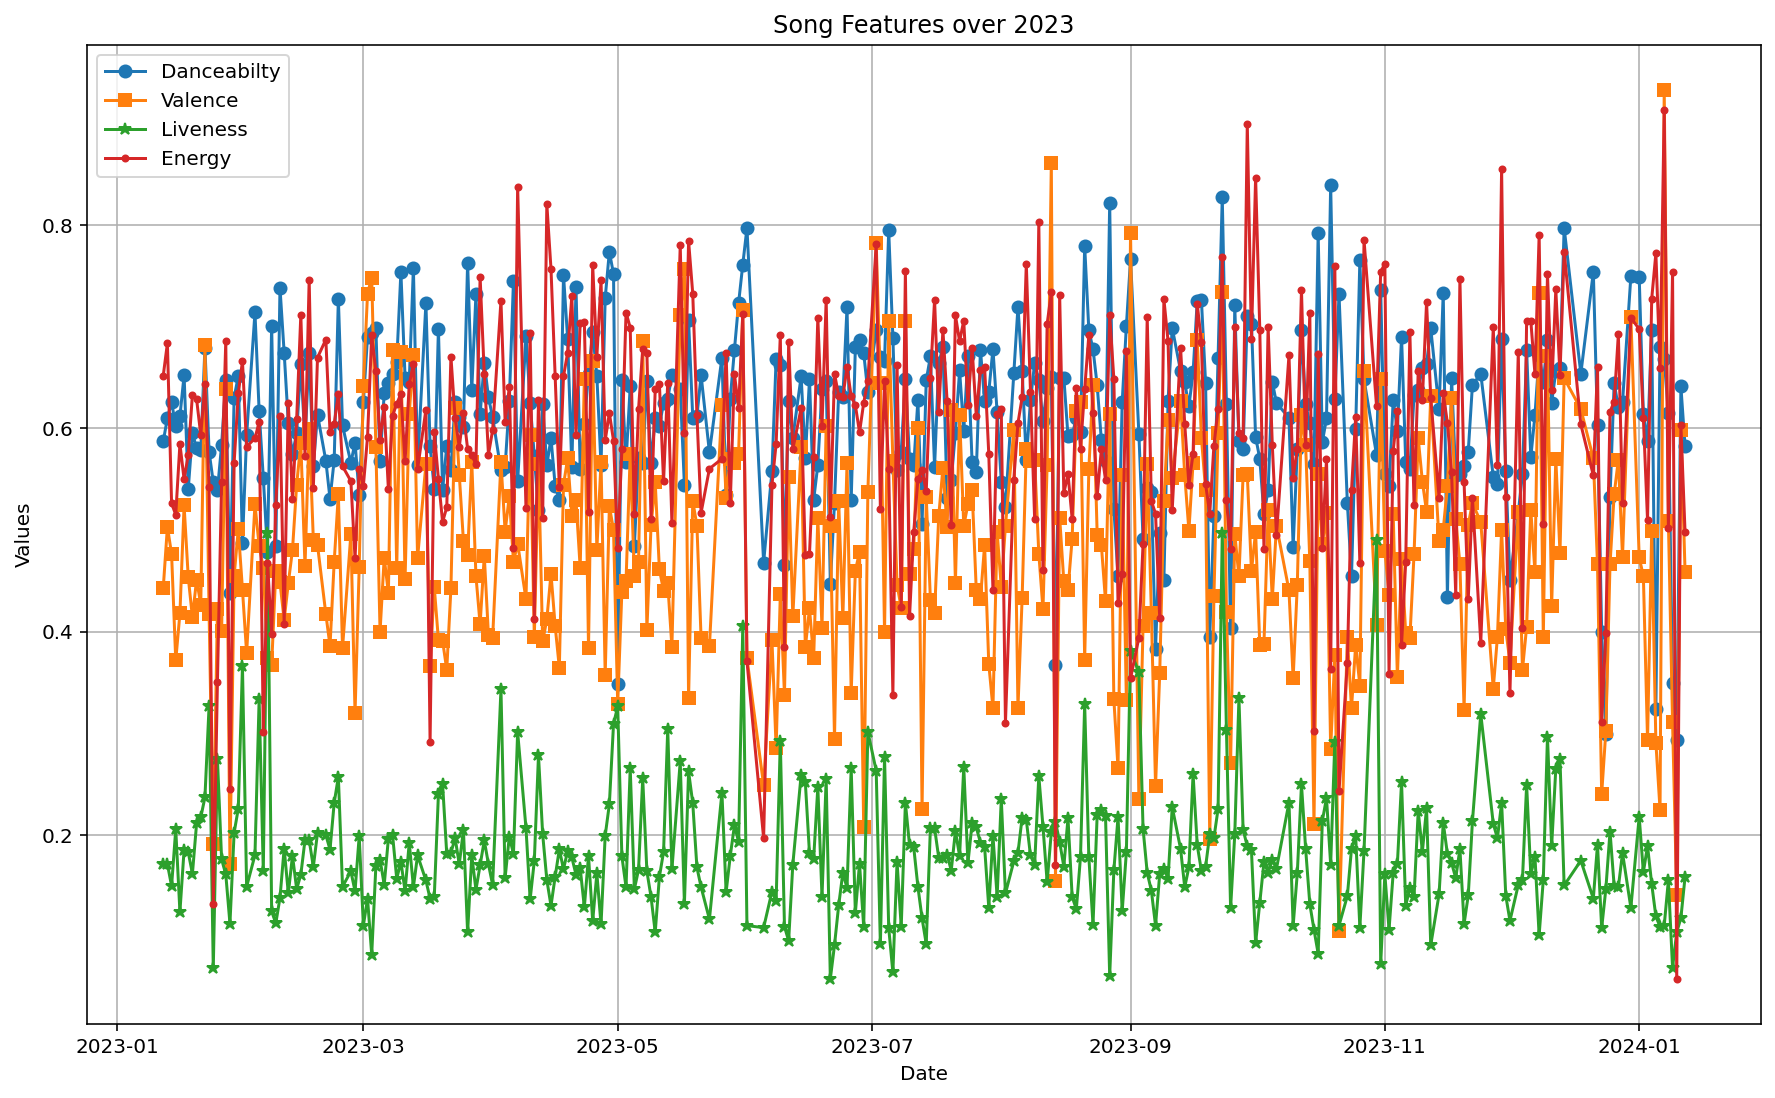

In [3]:
#curious to see how the average of these features looks over time, let's plot 

plt.figure(figsize=(15, 9))

# Plot each variable against dates
plt.plot(all_songs_aver_by_date['date'], all_songs_aver_by_date['danceability'], label='Danceabilty', marker='o')
plt.plot(all_songs_aver_by_date['date'], all_songs_aver_by_date['valence'], label='Valence', marker='s')
plt.plot(all_songs_aver_by_date['date'], all_songs_aver_by_date['liveness'], label='Liveness', marker='*')
plt.plot(all_songs_aver_by_date['date'], all_songs_aver_by_date['energy'], label='Energy', marker='.')
# Customize the plot

plt.title('Song Features over 2023')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

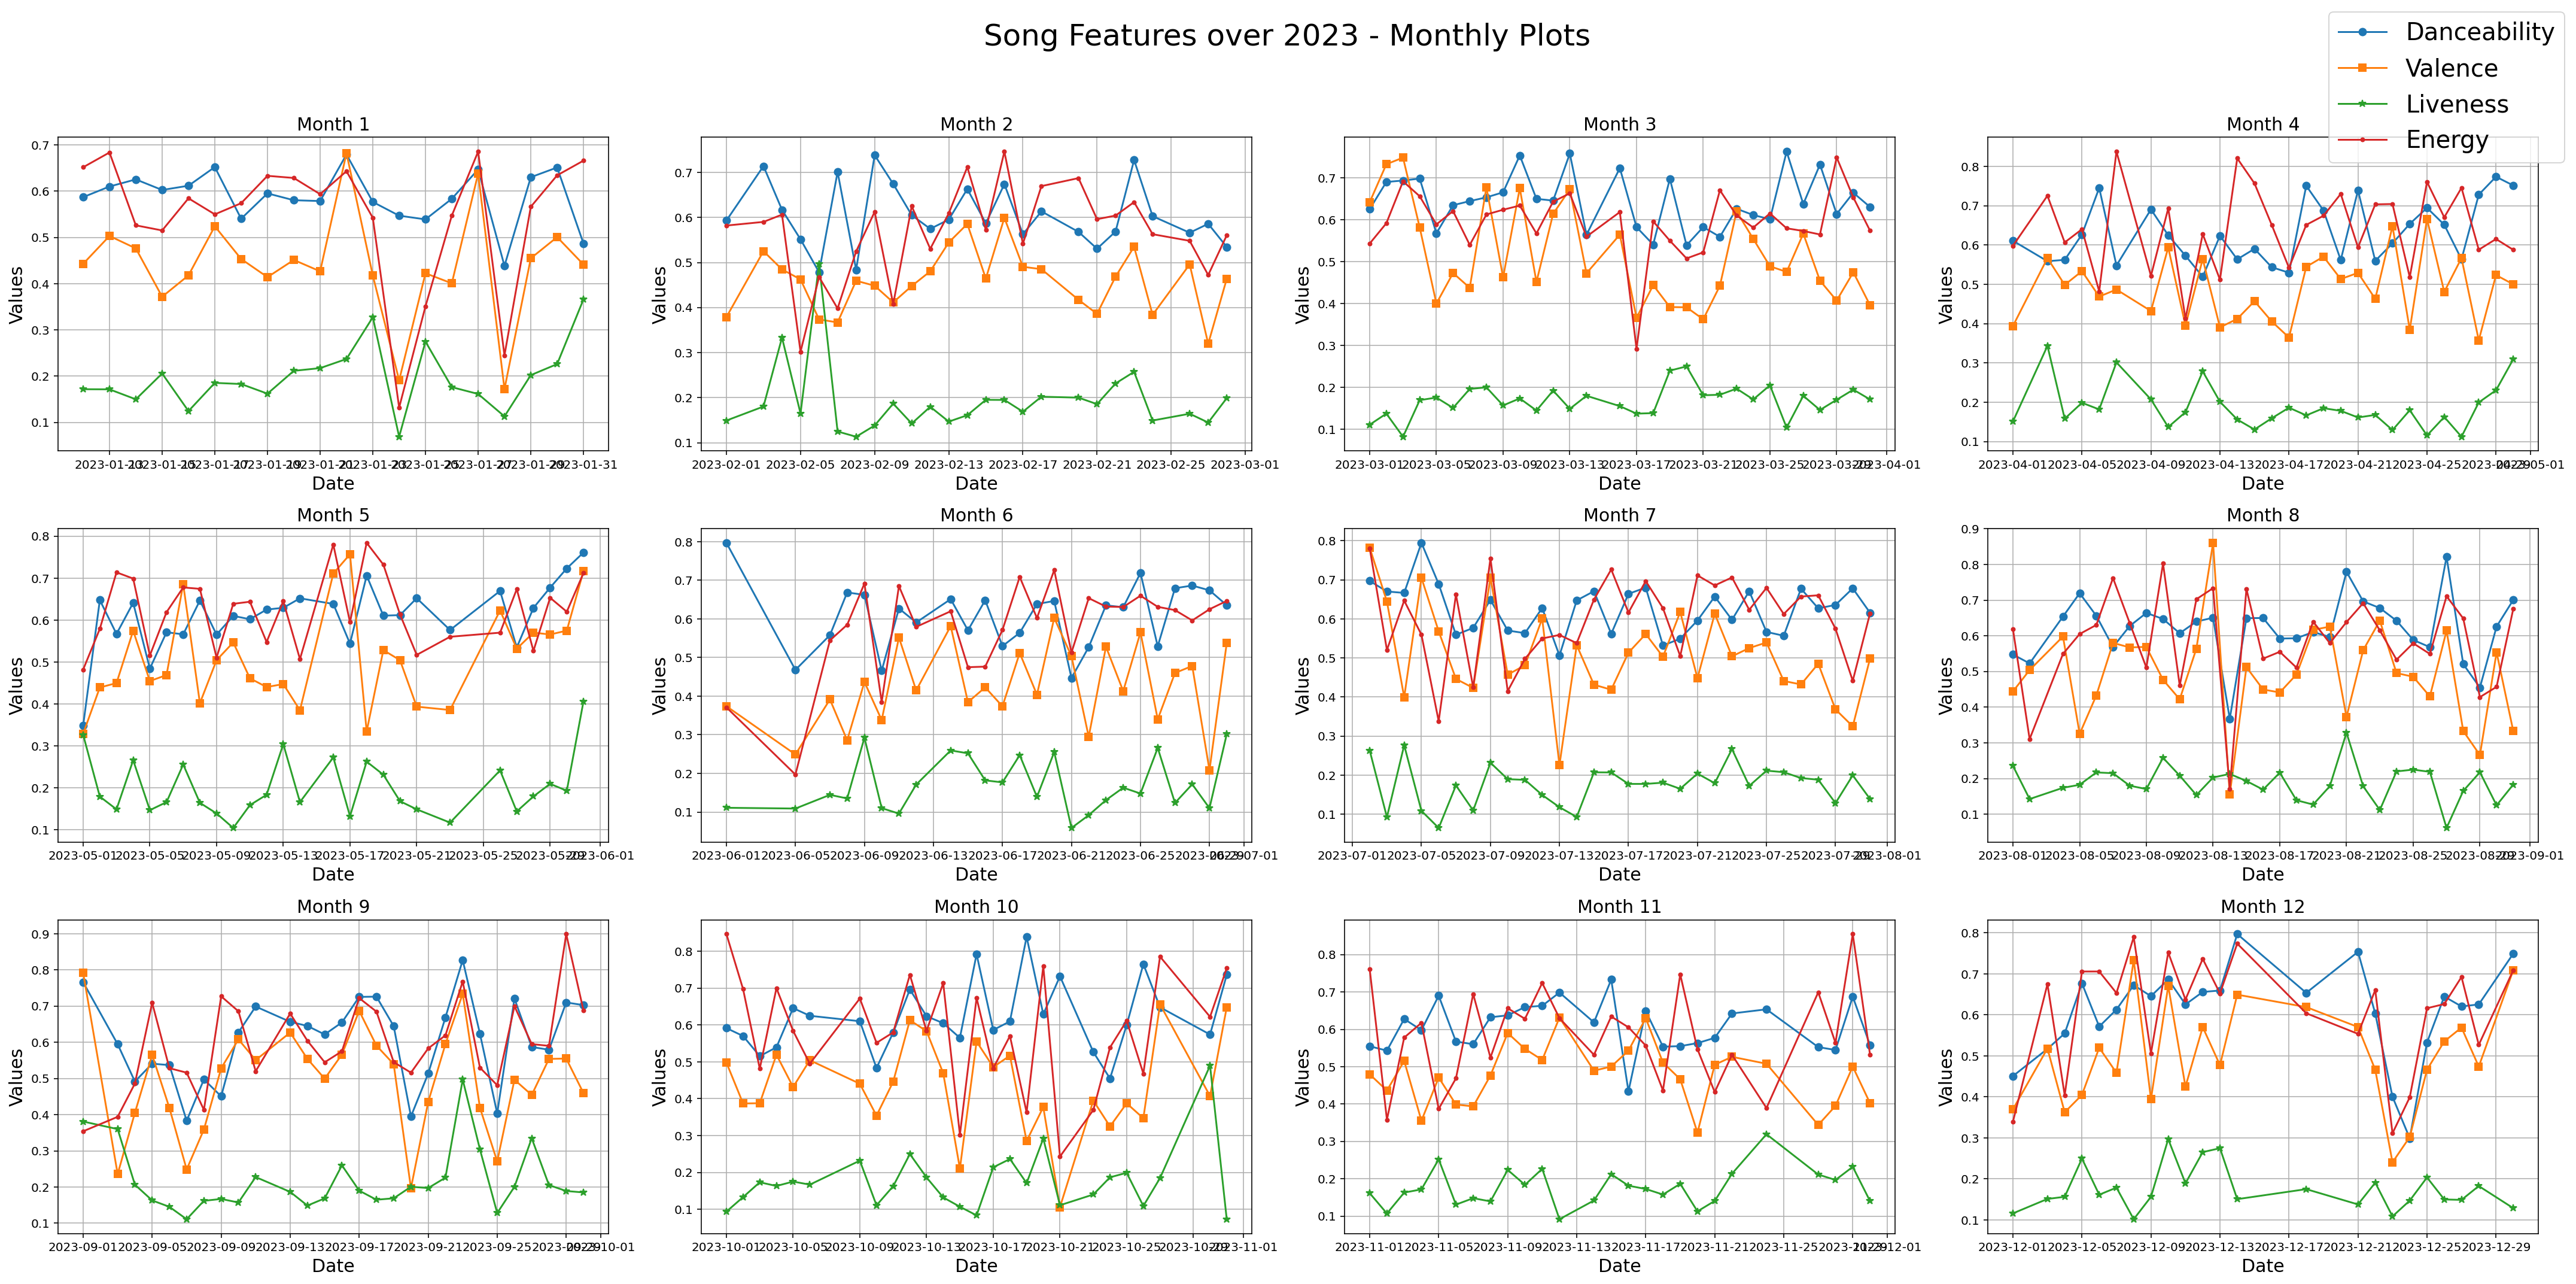

In [4]:
#I also want to see these variables per month in 2023, so let's plot all twelve months.



# convert 'date' column to datetime type just in case it's not already
all_songs_aver_by_date['date'] = pd.to_datetime(all_songs_aver_by_date['date'])

# getting month and year information from the 'date' column
all_songs_aver_by_date['month'] = all_songs_aver_by_date['date'].dt.month
all_songs_aver_by_date['year'] = all_songs_aver_by_date['date'].dt.year
all_songs_aver_by_date['year'] = all_songs_aver_by_date['year'].astype(int) #it was a string before
#spotify has also given me some songs that were actually played in 2024, so let's remove those to focus on 2023
all_songs_aver_by_date = all_songs_aver_by_date[all_songs_aver_by_date['year'] != 2024]


# Set up the figure and axis for subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
fig.suptitle('Song Features over 2023 - Monthly Plots', fontsize= 25)

# Iterate through each month
for month in range(1, 13):
    # Filter the data for the current month
    monthly_data = all_songs_aver_by_date[(all_songs_aver_by_date['month'] == month)]

    # Calculate the subplot position
    row = (month - 1) // 4
    col = (month - 1) % 4

    # Plot each variable against dates
    axs[row, col].plot(monthly_data['date'], monthly_data['danceability'], label='Danceability', marker='o')
    axs[row, col].plot(monthly_data['date'], monthly_data['valence'], label='Valence', marker='s')
    axs[row, col].plot(monthly_data['date'], monthly_data['liveness'], label='Liveness', marker='*')
    axs[row, col].plot(monthly_data['date'], monthly_data['energy'], label='Energy', marker='.')

    # Customize each subplot
    axs[row, col].set_title(f'Month {month}', fontsize = 15)
    axs[row, col].set_xlabel('Date', fontsize = 15)
    axs[row, col].set_ylabel('Values', fontsize = 15)
 
    axs[row, col].grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Add legend
fig.legend(['Danceability', 'Valence', 'Liveness', 'Energy'], loc='upper right', fontsize='20')

# Show the plots
plt.show()


## Comparing data from 2022 to 2023

So I have songs and all their features from 2022 too. For fun, let's see if we can use the features from the songs from 2022 as training data in a  machine learning model that will predict the features of the songs in 2023. 

P.S. I made these data frames by getting the unique songs for the year, getting the song id for each song, and getting the features for each song. 
Then, I concatenated all the streaming history jsons Spotify provides, and merged the df with the songs and features.
These resulting dataframes will have all the songs I listened to in that year, and all the features. Big dfs... in 2024 I listened to ~20k songs... 

In [5]:
#load in the songs and their features for each year

songs_2022 = pd.read_excel("2022 Songs and Features.xlsx")
songs_2023 = pd.read_excel("2023 Songs and Features.xlsx")



features_2022 = songs_2022[['danceability','valence','acousticness','energy','liveness', 'key', 'loudness','speechiness','instrumentalness', 'tempo']]
features_2023 = songs_2023[['danceability','valence','acousticness','energy','liveness', 'key', 'loudness','speechiness','instrumentalness', 'tempo']]

print("Song features from 2022 shape:",features_2022.shape)
print("Song features from 2023 shape:",features_2023.shape)

Song features from 2022 shape: (13259, 10)
Song features from 2023 shape: (22201, 10)


#### Let's plot a song feature from 2022 in a calendar plot

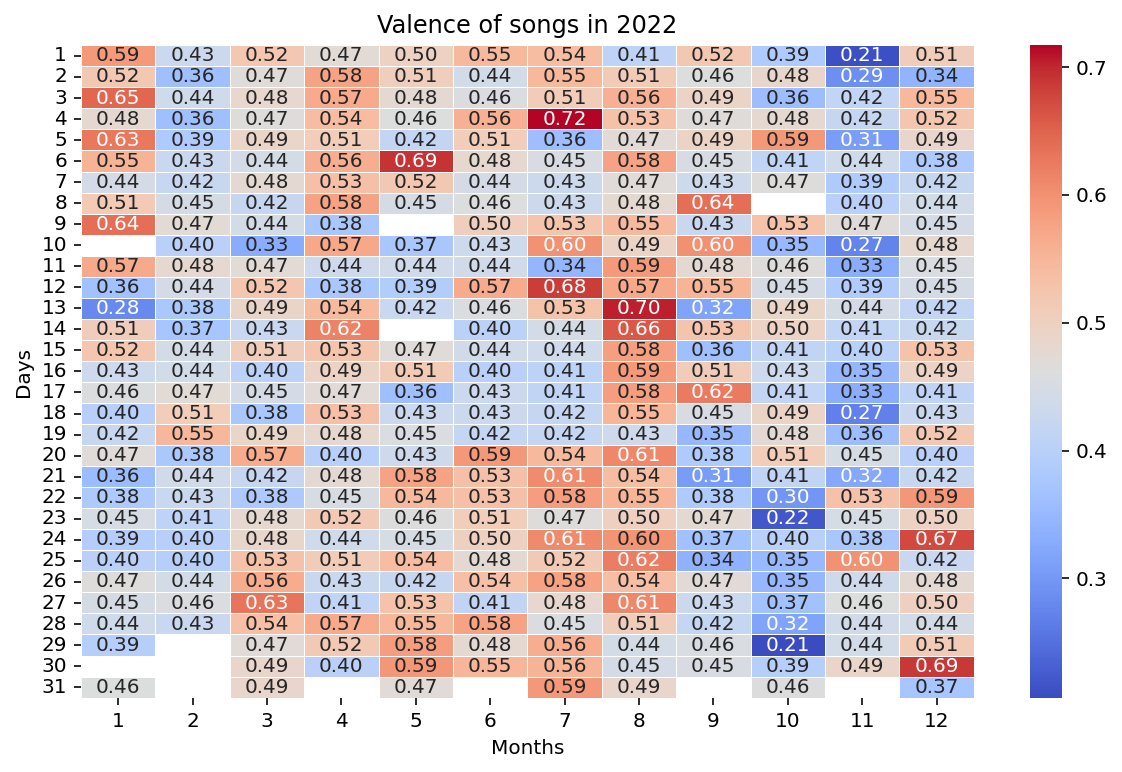

In [8]:


# Convert the 'date' column to datetime format if it's not already
songs_2022['endTime'] = pd.to_datetime(songs_2022['endTime'])

# Extract the year and month from the endtime
songs_2022['year'] = songs_2022['endTime'].dt.year
songs_2022['month'] = songs_2022['endTime'].dt.month
songs_2022['day'] = songs_2022['endTime'].dt.day

# Pivot the data
calendar_data = songs_2022.pivot_table(index='day', columns='month', values='valence', aggfunc='mean')

# Create the calendar plot
plt.figure(figsize=(10, 6))
sns.heatmap(calendar_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Valence of songs in 2022')
plt.xlabel('Months')
plt.ylabel('Days')
plt.show()


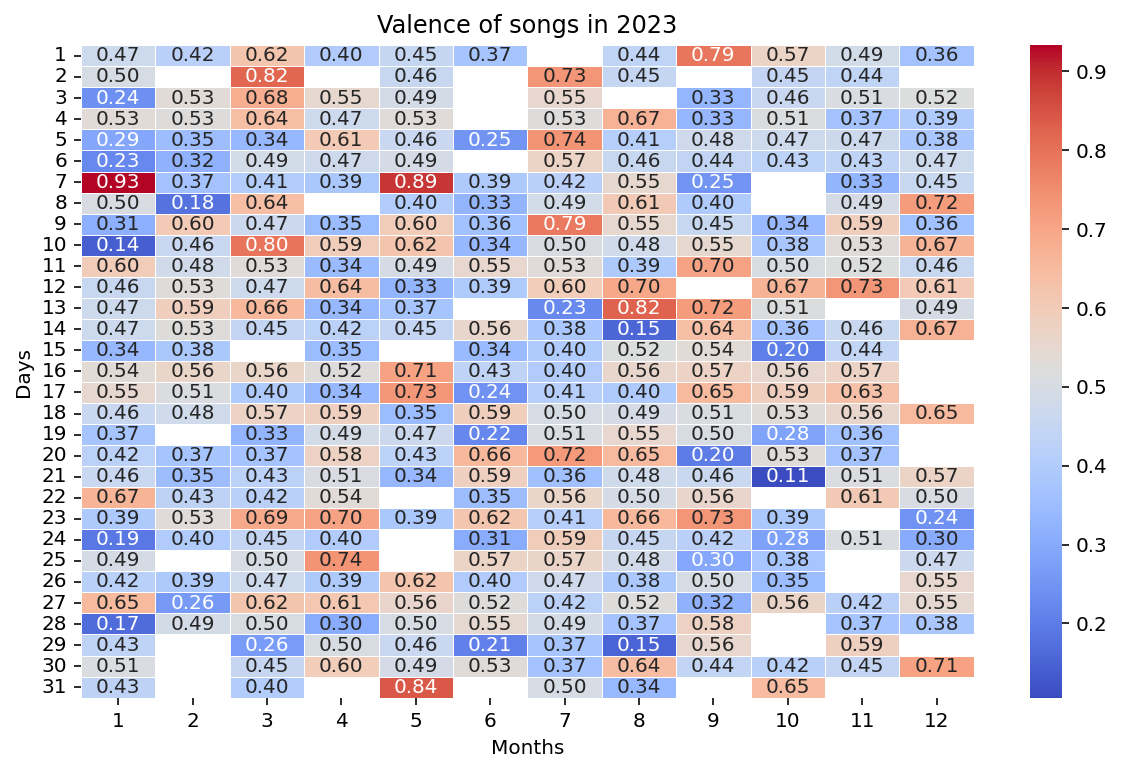

In [9]:

# Convert the 'date' column to datetime format if it's not already
songs_2023['endTime'] = pd.to_datetime(songs_2023['endTime'])

# Extract the year and month from the te
songs_2023['year'] = songs_2023['endTime'].dt.year
songs_2023['month'] = songs_2023['endTime'].dt.month
songs_2023['day'] = songs_2023['endTime'].dt.day


calendar_data = songs_2023.pivot_table(index='day', columns='month', values='valence', aggfunc='mean')

# Create the calendar plot
plt.figure(figsize=(10, 6))
sns.heatmap(calendar_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Valence of songs in 2023')
plt.xlabel('Months')
plt.ylabel('Days')
plt.show()


### Let's first see what correlations there are within a year.

Valence and danceability seem somewhat correlated (~0.45) for within both years.

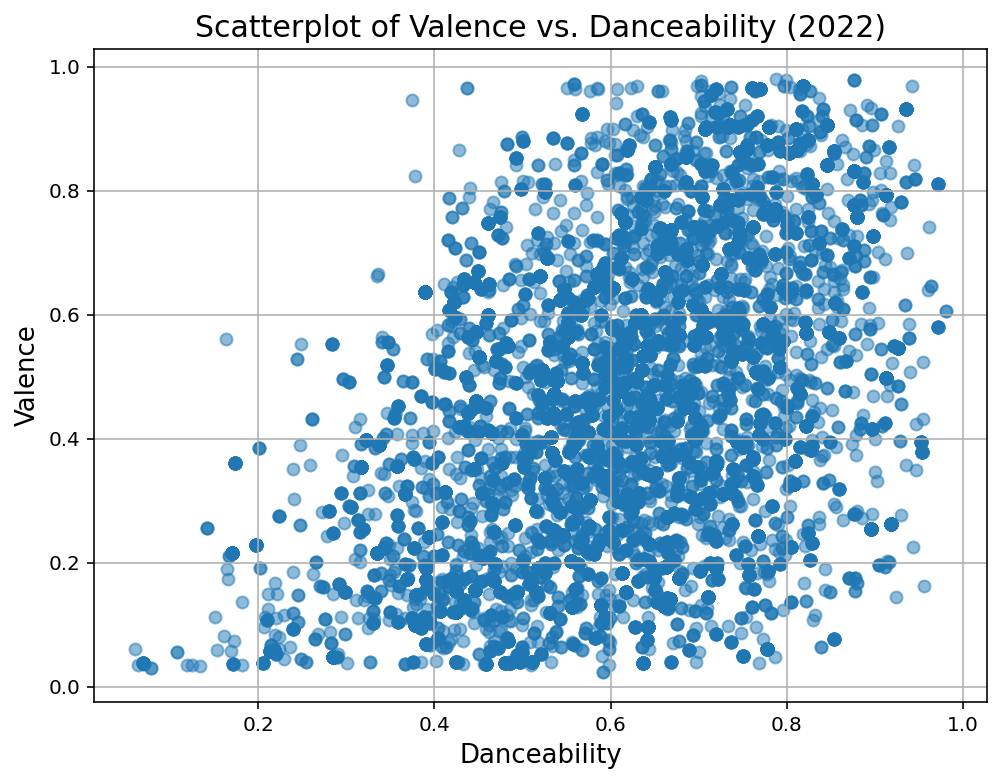

Correlation between Danceability and Valence: 0.45579436220067115


In [10]:

plt.figure(figsize=(8, 6))
plt.scatter(features_2022['danceability'], features_2022['valence'], alpha=0.5)
plt.title('Scatterplot of Valence vs. Danceability (2022)', fontsize= 15)
plt.xlabel('Danceability', fontsize = 13)
plt.ylabel('Valence', fontsize= 13)
plt.grid(True)
plt.show()

correlation = features_2022['danceability'].corr(features_2022['valence'])
print("Correlation between Danceability and Valence:", correlation)


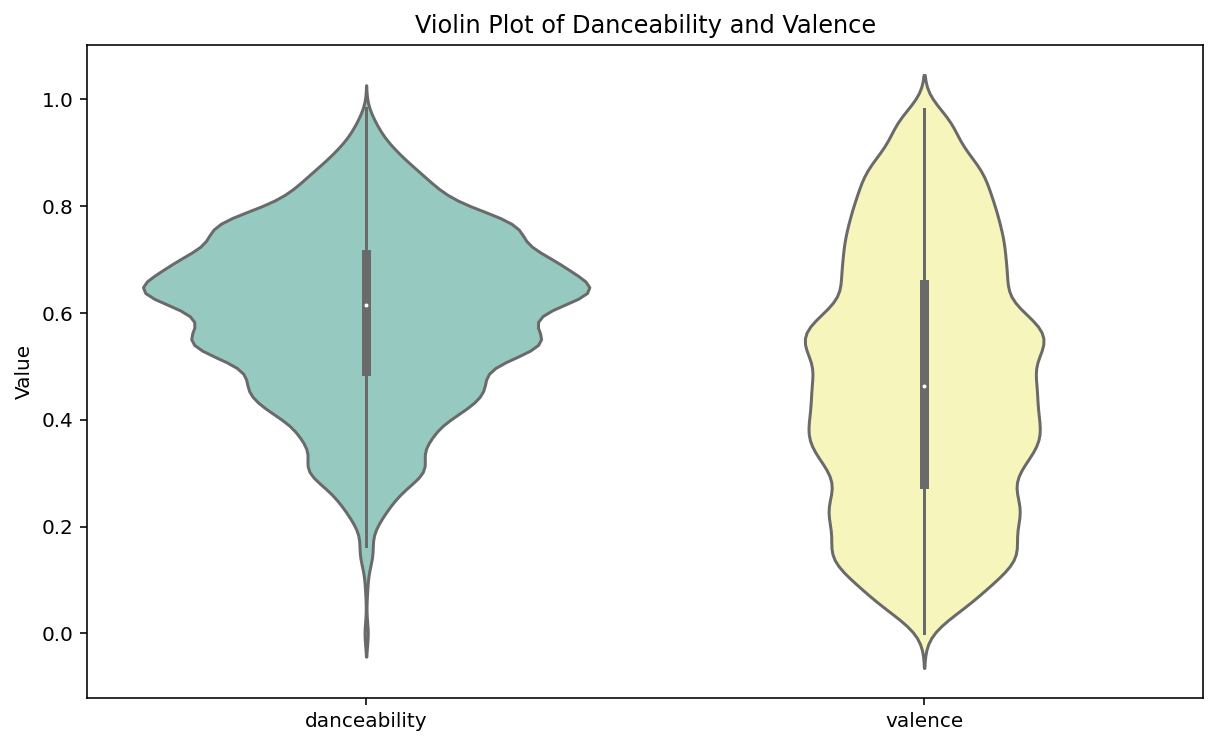

In [11]:
#randomly curious about their distribution. 

plt.figure(figsize=(10, 6))
sns.violinplot(data=features_2023[['danceability', 'valence']], palette="Set3")
plt.title('Violin Plot of Danceability and Valence')
plt.ylabel('Value')
plt.show()


Valence correlated with danceability in 2023

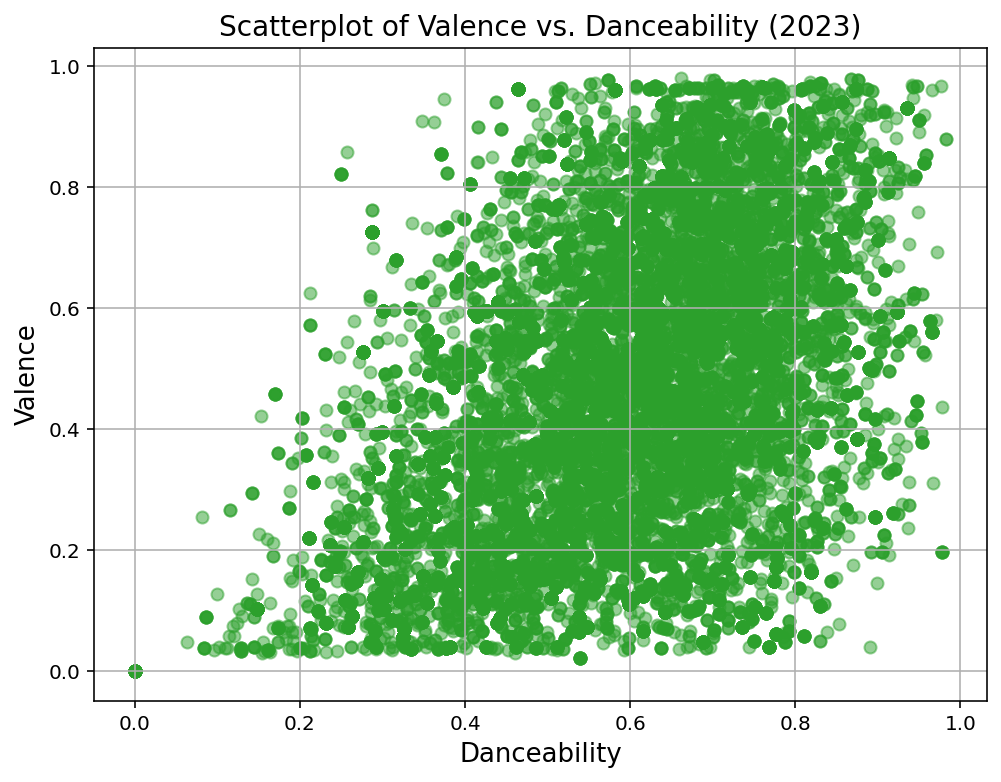

Correlation between Danceability and Valence: 0.4598594424238343


In [12]:

plt.figure(figsize=(8, 6))
plt.scatter(features_2023['danceability'], features_2023['valence'], alpha=0.5, color='tab:green')
plt.title('Scatterplot of Valence vs. Danceability (2023)', fontsize=14)
plt.xlabel('Danceability', fontsize=13)
plt.ylabel('Valence', fontsize=13)
plt.grid(True)
plt.show()

correlation = features_2023['danceability'].corr(features_2023['valence'])
print("Correlation between Danceability and Valence:", correlation)

### Let's plot some correlations between features across years now

I listened to less songs in 2022 than I did in 2023, so let's randomly select samples from 2023 so they are the same shape for the correlations / model

In [13]:

num_samples_2022 = len(features_2022)

# Randomly select a subset of samples from features_2023
features_2023_subset = features_2023.sample(n=num_samples_2022, random_state=42)
print("Subset of song features from 2023 shape:", features_2023_subset.shape)

Subset of song features from 2023 shape: (13259, 10)


Across years, the features don't seem to be all that correlated. Which is surprising, because I thought I listened to similar songs across years. 

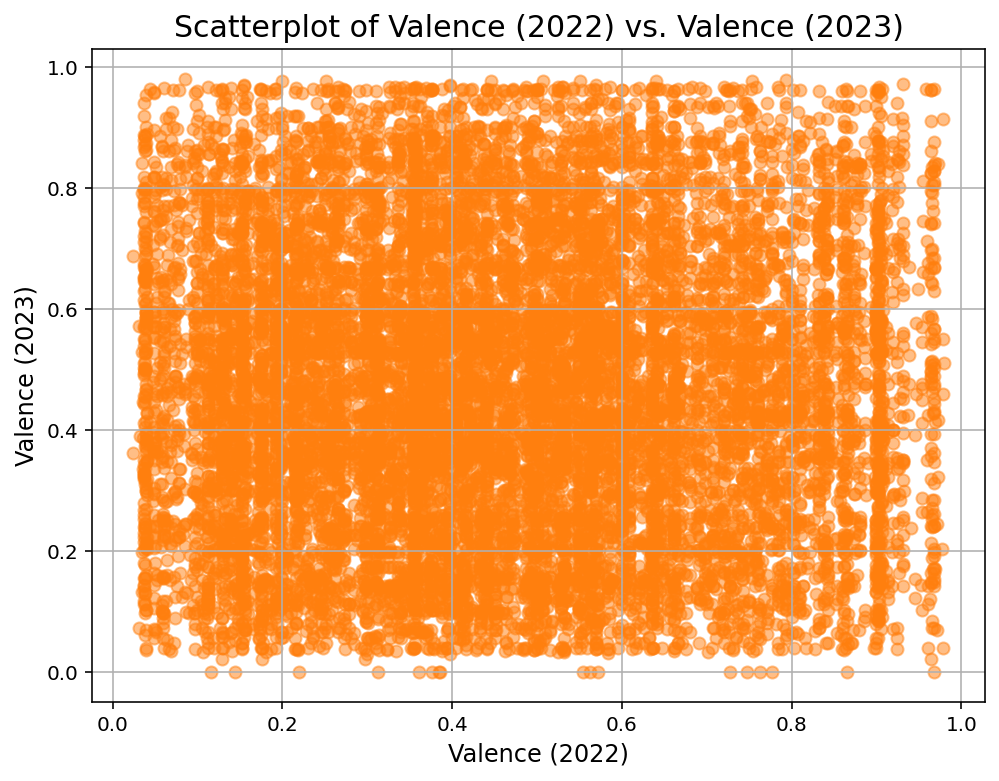

Correlation between Valence (2022) and Valence (2023): -0.03385965676533918


In [14]:
#lets plot the correlation 
plt.figure(figsize=(8, 6))
plt.scatter(features_2022['valence'], features_2023_subset['valence'], alpha=0.5, c='tab:orange')
plt.title('Scatterplot of Valence (2022) vs. Valence (2023)', fontsize=15)
plt.xlabel('Valence (2022)', fontsize=12)
plt.ylabel('Valence (2023)', fontsize= 12)
plt.grid(True)
plt.show()

correlation = features_2022['valence'].corr(features_2023_subset['valence'])
print("Correlation between Valence (2022) and Valence (2023):", correlation)

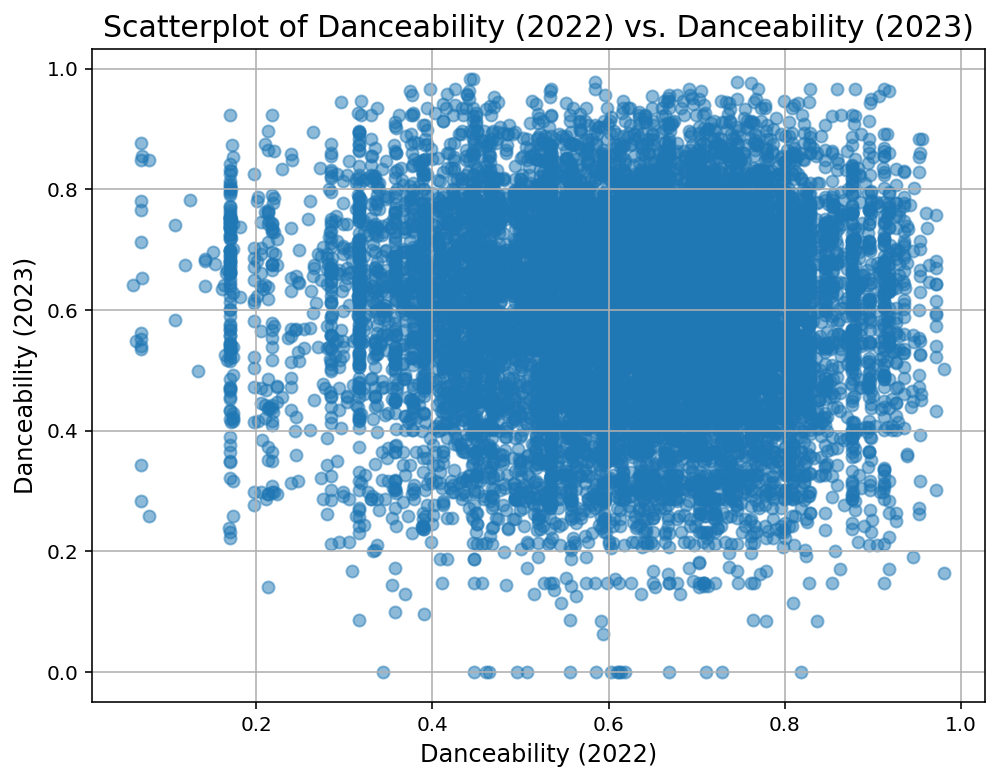

Correlation between Danceability (2022) and Danceability (2023): -0.05953790410610448


In [15]:
#let's plot the correlation 
plt.figure(figsize=(8, 6))
plt.scatter(features_2022['danceability'], features_2023_subset['danceability'], alpha=0.5)
plt.title('Scatterplot of Danceability (2022) vs. Danceability (2023)', fontsize = 15)
plt.xlabel('Danceability (2022)', fontsize=12)
plt.ylabel('Danceability (2023)', fontsize=12)
plt.grid(True)
plt.show()

correlation = features_2022['danceability'].corr(features_2023_subset['danceability'])
print("Correlation between Danceability (2022) and Danceability (2023):", correlation)

### Using Linear SVR to create a machine learning model


So the features don't correlate well across years, but for fun, let's see if a feature from one year could predict
that same feature the next year. 

Spoiler alert: The model doesn't seem to fit well. :( On any feature, but see valence and danceability alone. This may just be the case with the linear model, or my music tastes changed? Or random variation? Hm. 

In [20]:


x = 'valence'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_2022[[x]], features_2023_subset[[x]], test_size=0.2, random_state=42)

# Initialize the Linear SVM model
model = LinearSVR()

# Reshape y_train and y_test to 1D arrays
y_train_reshaped = y_train.values.ravel()
y_test_reshaped = y_test.values.ravel()

# Train the model
model.fit(X_train, y_train_reshaped)


# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.19806292214742832
Mean Squared Error: 0.05598419759416655
R-squared: -0.0012196667761670277


In [17]:


x = 'danceability'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_2022[[x]], features_2023_subset[[x]], test_size=0.2, random_state=42)

# Initialize the Linear SVM model
model = LinearSVR()

# Reshape y_train and y_test to 1D arrays
y_train_reshaped = y_train.values.ravel()
y_test_reshaped = y_test.values.ravel()

# Train the model
model.fit(X_train, y_train_reshaped)


# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.12812333029471057
Mean Squared Error: 0.026150698441507598
R-squared: -0.019517630024434185


### Across years isn't working too well.
Well, let's see explore some things within a year. Like can one feature predict another?

1. Valence (predictor) and danceability in 2022?
2. Valence (predictor) and danceability in 2023? 

Seems like within years, one feature can predict another. Below, valence and danceability may have some linear relationship. Valence explains ~20% of the variability in danceability, in both years! 

In [18]:


x = 'valence'
y = 'danceability'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_2022[[x]], features_2022[[y]], test_size=0.2, random_state=42)

# Initialize the Linear SVM model
model = LinearSVR()

# Reshape y_train and y_test to 1D arrays
y_train_reshaped = y_train.values.ravel()
y_test_reshaped = y_test.values.ravel()

# Train the model
model.fit(X_train, y_train_reshaped)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test_reshaped, predictions)
mse = mean_squared_error(y_test_reshaped, predictions)
r2 = r2_score(y_test_reshaped, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.11202992932705479
Mean Squared Error: 0.020125438252326447
R-squared: 0.20213888385195633


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = 'valence'
y= 'danceability'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_2023[[x]], features_2023[[y]], test_size=0.2, random_state=42)

# Initialize the Linear SVM model
model = LinearSVR()

# Reshape y_train and y_test to 1D arrays
y_train_reshaped = y_train.values.ravel()
y_test_reshaped = y_test.values.ravel()

# Train the model
model.fit(X_train, y_train_reshaped)


# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.11427066921606552
Mean Squared Error: 0.02040300474110945
R-squared: 0.2175109013738603


That's about it! Can play with what features are the predictor vs. the predicted, and maybe can fine which features predict the data within a year the best. 